# Robustness of SimpleNet vs MirrorNet

Based on this it seems like very simple networks are quite robust to gradient based adversaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

from simplenet import *
from mirrornet import *

from utils import *

gpu_dtype = torch.cuda.FloatTensor

loader_train, loader_val, loader_test = get_cifar_loaders()

In [25]:
from importlib import reload

import simplenet
reload(simplenet)
from simplenet import *

import utils
reload(utils)
from utils import *

simplenet = SimpleNet().cuda()
# mirrornet = MirrorNet().cuda()
print(get_param_count(simplenet))
# print(get_param_count(mirrornet))

413386


In [26]:
simpletrainer = Trainer(simplenet, loader_train, loader_val)

# train(simplenet, loader_train, loader_val, schedule_epochs=[10, 5, 2])
# train(mirrornet, loader_train, loader_val, schedule_epochs=[10, 5, 2])

In [27]:
simpletrainer.train_schedule([1, 1, 1])

Training for 1 epochs with learning rate 0.100000
Starting epoch 1 / 1
loss = 1.7961
Got 1766 / 5000 correct (35.32)
Training for 1 epochs with learning rate 0.100000
Starting epoch 1 / 1
loss = 1.4926
Got 2309 / 5000 correct (46.18)
Training for 1 epochs with learning rate 0.100000
Starting epoch 1 / 1
loss = 1.3387
Got 2554 / 5000 correct (51.08)


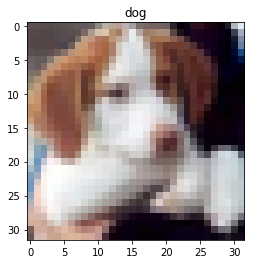

dog


In [128]:
images, labels = iter(loader_test).next()
i = 16
image, label = images[i, np.newaxis], labels[i]
img_var = Variable(image.cuda(), requires_grad=True)
imshow(image, label)
print(CIFAR_CLASSES[simplenet(img_var).max(0)[1].data[0]])

dog
dog
dog
dog
dog
dog
horse
horse
horse
horse


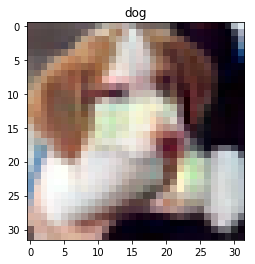

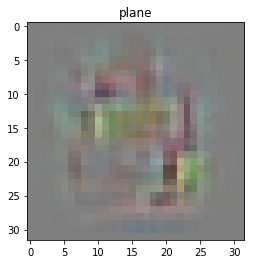

In [180]:
def adversarial_attack(model, img_var):
    for param in model.parameters():
        param.requires_grad = False
    
    target = 4
    
    alpha = .005
    adv_img_var = Variable(img_var.data.clone(), requires_grad=True)
    
    difference = torch.zeros_like(adv_img_var.data)
    
    num_epochs = 1000
    for epoch in range(num_epochs):
        scores = model(adv_img_var)

        objective = scores.squeeze()[target]
        objective.backward()
        g = adv_img_var.grad.data.clone()
        adv_img_var.grad.zero_()
        g = g / g.norm()

        diff_epoch = alpha * g
        adv_img_var.data += diff_epoch.cuda()
        difference += diff_epoch
        adv_img_var.data = torch.clamp(adv_img_var.data, min=-1, max=1)
        difference = torch.clamp(difference, min=-1, max=1)
        
#         print(scores.data[target])\
        if epoch % 100 == 0:
            print(CIFAR_CLASSES[scores.max(0)[1].data[0]])
#         print(scores.data.cpu().numpy())
    
    for param in model.parameters():
        param.requires_grad = True
    
    return adv_img_var, difference

adv_img_var, difference = adversarial_attack(simplenet, img_var)

imshow(adv_img_var.data.cpu().numpy(), label)
imshow(difference.cpu().numpy(), 0)
# imshow(img_var.data.cpu().numpy(), label)